# This is just a notebook to visualise 1kHz filtered raw data

## Setup everything

### Import packages

In [1]:
import os
import sys
import quantities as pq
import numpy as np
import neo
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
import scipy
from scipy import interpolate
from scipy import fftpack
from scipy import signal
from open_ephys.analysis import Session

from PyQt6 import QtCore

import mmap
import xarray as xr
import dask.array as da
#%matplotlib widget


from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter


from ipyfilechooser import FileChooser

### Define params

In [2]:
numChanels=64

### Define mapping dict

chanelsMap is a dictionary with one key per brain region and/or canal of interest (TTL). The value associated to the key is an array with every corresponding canal. The "status" key defines which of these canals to use for analyses:
- 0: not to use
- 1 only: floating point canal
- 1 and 2: differential signal 2-1

In [3]:
chanelsMap = dict( \
    EMG = [dict(canal = 6, status=1)],
    PFC = [dict(canal = 5, status=1),
           dict(canal = 4, status=2)
           ],
    CA1 = [dict(canal = 8, status=1),
           dict(canal = 0, status=0),
           dict(canal = 1, status=0),
        ],
    TTL = [dict(canal = 10, status=1)],
)

### Define functions

#### Read data file

In [4]:
def other_mmap(filename, shape, dtype, chunks):
    with open(filename, "rb") as fh:
        # `mmap` duplicates the file descriptor
        # `0` means map the full file
        mm = mmap.mmap(fh.fileno(), 0, access=mmap.ACCESS_READ)

    # coerce to NumPy array of expected type and shape
    a = np.asarray(mm).view(dtype).reshape(shape)

    # Don't call `asarray`
    # name=False to avoid hashing
    a_d = da.from_array(a, chunks=chunks, asarray=False, name=False)
    return a_d

#### Choose path

In [5]:
expePath = None
subpath4FPGA = None
fileBaseName = None

%store -r expePath subpath4FPGA fileBaseName
if expePath is None:
    expePath = "/Users/mb/Documents/Syntuitio/AudreyHay/PlanB/"
    print("The experiment path is not in strore yet, setting it to default: {}".format(expePath))

if subpath4FPGA is None:
    subpath4FPGA = "recording8/continuous/Rhythm_FPGA-133.0/"
    print("The experiment path is not in strore yet, setting it to default: {}".format(subpath4FPGA))

if fileBaseName is None:
    fileBaseName = "continuous.dat"
    print("The experiment path is not in strore yet, setting it to default: {}".format(fileBaseName))


fc = FileChooser(path=os.path.join(expePath,subpath4FPGA), filename=fileBaseName,select_default=True, show_only_dirs = False, title = "<b>ePhys data</b>")
display(fc)

# Sample callback function
def update_my_folder(chooser):
    global expePath, subpath4FPGA, fileBaseName
    filePath = chooser.selected
    subpath4FPGA = ""
    fileBaseName = os.path.basename(filePath)
    print("Storing filename: {}".format(fileBaseName))
    level=4
    for i in range(level):
        filePath = os.path.dirname(filePath)
        if i < level-1:
            subpath4FPGA = os.path.basename(filePath) + "/" + subpath4FPGA
    expePath = filePath
    print("Storing experiement path: {}".format(expePath))
    print("Storing subpath: {}".format(subpath4FPGA))
    %store expePath subpath4FPGA fileBaseName
    return 

# Register callback function
fc.register_callback(update_my_folder)

FileChooser(path='/Users/mb/Documents/Syntuitio/AudreyHay/PlanB/recording8/continuous/Rhythm_FPGA-133.0', file…

## Load Data

### Map the whole data into memory

In [6]:
filename = os.path.join(expePath,subpath4FPGA,fileBaseName)

if fileBaseName == "continuous.dat":
    All = np.memmap(filename, mode='r', dtype='int16')
    #All = np.fromfile(filename, dtype="int16")
    All = All.reshape(-1,numChanels)
elif fileBaseName.endswith(".npy"):
    All = np.load(filename, mmap_mode= 'r')

In [7]:
filenameT = filename = os.path.join(expePath,subpath4FPGA,"timestamps.npy")
Timestamps = np.load(filenameT)
Timestamps.shape
Timestamps = Timestamps*2000
Timestamps = Timestamps.astype(int)
Timestamps

array([506597888000, 506597890000, 506597892000, ..., 553625594000,
       553625596000, 553625598000])

### Extract submatrix of interest

In [8]:
start = 000000
end = All.shape[0]
combined = np.empty((end-start,0),np.int16)
channelLabels = []
for region in chanelsMap:
    print(region, "->", chanelsMap[region])
    if len([canal["canal"] for canal in chanelsMap[region] if canal["status"]==2])>0:
        c2 = [canal["canal"] for canal in chanelsMap[region] if canal["status"]==2][0]
        c1 = [canal["canal"] for canal in chanelsMap[region] if canal["status"]==1][0]
        print("Getting differential signal of channel {} - channel {} for {}".format(c2,c1,region))
        channelLabels.append(region)
        combined = np.append(combined, All[start:end, c2, np.newaxis] - All[:, c1, np.newaxis], axis=1)
    elif len([canal["canal"] for canal in chanelsMap[region] if canal["status"]==1])>0:
        c = [canal["canal"] for canal in chanelsMap[region] if canal["status"]==1][0]
        print("Getting floating signal of channel {} for {}".format(c,region))
        combined = np.append(combined, All[start:end,c, np.newaxis], axis=1)
        channelLabels.append(region)

EMG -> [{'canal': 6, 'status': 1}]
Getting floating signal of channel 6 for EMG
PFC -> [{'canal': 5, 'status': 1}, {'canal': 4, 'status': 2}]
Getting differential signal of channel 4 - channel 5 for PFC
CA1 -> [{'canal': 8, 'status': 1}, {'canal': 0, 'status': 0}, {'canal': 1, 'status': 0}]
Getting floating signal of channel 8 for CA1
TTL -> [{'canal': 10, 'status': 1}]
Getting floating signal of channel 10 for TTL


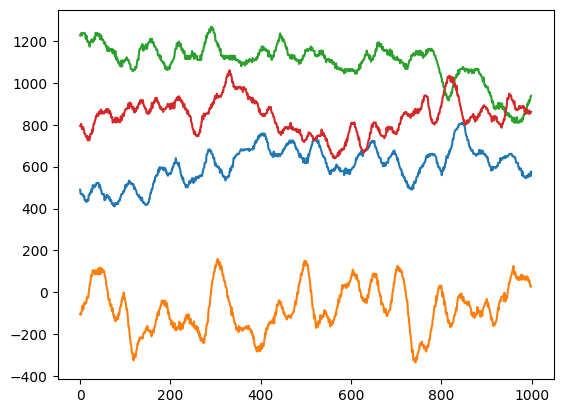

In [9]:
plt.plot(combined[:1000,:])
plt.show()

In [10]:
%gui qt 
# allows the app to be closed clean and reopen
app = mkQApp()


sample_rate = 1000.
t_start = 0.

TTL = Timestamps

#create 2 familly scatters from theses 2 indexes
scatter_indexes = {0: TTL, 1: TTL}
#and asign them to some channels each
scatter_channels = {0: [0, 12], 1: [0, 1]}
source = AnalogSignalSourceWithScatter(All, sample_rate, t_start, scatter_indexes, scatter_channels)


#Create the main window that can contain several viewers
win = MainViewer()
view1 = TraceViewer.from_numpy(combined, sample_rate, t_start, 'Signals', channel_names=channelLabels)
#view1 = TraceViewer(source=source)
win.add_view(view1)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True

view1.by_channel_params['ch0', 'gain'] = 0.00002
view1.by_channel_params['ch1', 'gain'] = 0.00004
view1.by_channel_params['ch2', 'gain'] = 0.00004
view1.by_channel_params['ch3', 'gain'] = 0.00005
#view1.by_channel_params['ch4', 'gain'] = 0.00005

view1.by_channel_params['ch0', 'offset'] = 0.1
view1.by_channel_params['ch1', 'offset'] = 0.05
view1.by_channel_params['ch2', 'offset'] = -0.0
view1.by_channel_params['ch3', 'offset'] = -0.05
#view1.by_channel_params['ch4', 'offset'] = -0.1

#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#aa0000'
view1.by_channel_params['ch1', 'color'] = '#ff5500'
view1.by_channel_params['ch2', 'color'] = '#9b3b70'
view1.by_channel_params['ch3', 'color'] = '#0055ff'


#Run
win.show()
app.exec()

qt.svg: Cannot open file ':/media-playback-start.svg', because: No such file or directory
qt.svg: Cannot open file ':/media-playback-start.svg', because: No such file or directory
qt.svg: Cannot open file ':/media-playback-stop.svg', because: No such file or directory
qt.svg: Cannot open file ':/media-playback-stop.svg', because: No such file or directory
qt.pointer.dispatch: skipping QEventPoint(id=4 ts=0 pos=0,0 scn=546.152,429.523 gbl=546.152,429.523 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-546.152,-429.523 last=-546.152,-429.523 Δ 546.152,429.523) : no target window
qt.pointer.dispatch: skipping QEventPoint(id=4 ts=0 pos=0,0 scn=406.13,530.006 gbl=406.13,530.006 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-406.13,-530.006 last=-406.13,-530.006 Δ 406.13,530.006) : no target window
qt.pointer.dispatch: skipping QEventPoint(id=4 ts=0 pos=0,0 scn=652.433,428.045 gbl=652.433,428.045 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-652.433,-428.045 last=-652.433,-428.045 Δ 652.433,428.045) : no t

In [ ]:
combined.shape

(23513856, 4)

TypeError: unsupported operand type(s) for /: 'str' and 'str'

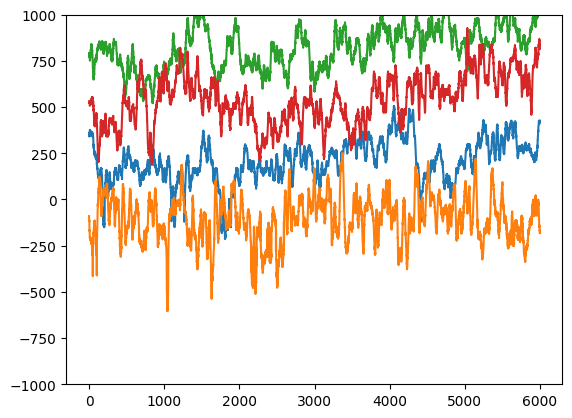

In [ ]:
combined2 = combined[363000:369000,:]
#times = np.arange(0, 2000/2000, 1./2000)
#tt = times[363000:369000]
Cortext = combined2

plt.close('all')
plt.plot(Cortext)
plt.ylim((-1000,1000))

filename = expePath / f'extract.svg'
plt.savefig(filename, format="svg")

# folder_base = Path('Gaelle/Baseline_recording/GreenLinesOK/session3/OpenEphys/')
folder_base = Path('/Users/ahay/Documents/DATA/DREADDthalamus/JessyTest/2201/')

filename = folder_base / f'RawDataChannelExtractedDS.npy'
filename2 = folder_base / f'RawDataChannelExtractedDS.npy'

All = np.load(filename2, mmap_mode= 'r')
All0 = np.load(filename, mmap_mode= 'r')
combined0 = All[3000000:4000000,22:26].copy()
combined1 = All0[3000000:4000000:,20:22].copy()
combined11 = All0[3000000:4000000:,26:28].copy()
combined12 = All0[3000000:4000000:,0:2].copy()
combined13 = All0[3000000:4000000:,14:16].copy()
combined14 = All0[3000000:4000000:,2:4].copy()
combined15 = All0[3000000:4000000:,12:14].copy()
combined21 = np.append(combined0, combined1, axis=1)
combined22 = np.append(combined21, combined11, axis=1)
combined23 = np.append(combined22, combined12, axis=1)
combined24 = np.append(combined23, combined13, axis=1)
combined25 = np.append(combined24, combined14, axis=1)
combined2 = np.append(combined25, combined15, axis=1)
All.shape
All2 = All.copy()
All2 = All2.T
All2.shape

plt.close()
All3t = All3[3587000:3602000,:]
times = np.arange(3587000, 3602000, 1)
plt.plot(times, All3t)
plt.show()

filename = folder_base / f'plot.svg'
plt.savefig(filename, format="svg")